In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
pd.options.display.max_columns = 100

## Pre-processing

In [2]:
over_unders = pd.read_csv('historical_over_under_data.csv')
stats = pd.read_csv('team_stats_00_22.csv')

In [3]:
print(over_unders.shape)
over_unders.head()

(578, 4)


,Team,win_total,actual_wins,result
0,Atlanta Hawks_00,46.5,28,U
1,Atlanta Hawks_02,36.5,33,U
2,Atlanta Hawks_03,41.5,35,U
3,Atlanta Hawks_04,33.0,28,U
4,Atlanta Hawks_05,27.5,13,U


In [4]:
print(stats.shape)
stats.head()

(595, 24)


,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA
0,Utah Jazz_20,28.5,52.0,20.0,55,17,9.25,-0.29,8.97,117.6,108.3,9.3,98.5,0.244,0.488,0.597,0.563,12.7,24.5,0.195,0.507,10.3,79.3,0.159
1,Los Angeles Clippers_20,28.8,47.0,25.0,49,23,6.18,-0.16,6.02,117.6,111.2,6.4,96.9,0.222,0.400,0.599,0.564,12.2,22.7,0.186,0.531,11.9,79.1,0.186
2,Phoenix Suns_20,26.6,51.0,21.0,49,23,5.82,-0.15,5.67,117.2,111.3,5.9,97.2,0.212,0.392,0.597,0.564,11.5,20.8,0.177,0.534,12.4,78.5,0.194
3,Milwaukee Bucks_20,28.1,46.0,26.0,48,24,5.89,-0.32,5.57,117.2,111.4,5.8,102.2,0.233,0.404,0.593,0.566,12.0,23.3,0.177,0.536,11.5,79.7,0.157
4,Philadelphia 76ers_20,27.1,49.0,23.0,48,24,5.58,-0.31,5.28,113.2,107.6,5.6,99.5,0.293,0.347,0.579,0.541,12.8,23.2,0.225,0.521,13.8,78.2,0.200


In [5]:
o_u_teams = over_unders['Team'].map(lambda x: x[:-3])
o_u_teams.value_counts().sort_values(ascending = False)

Atlanta Hawks             20
Miami Heat                20
Brooklyn Nets             20
Chicago Bulls             20
Cleveland Cavaliers       20
Dallas Mavericks          20
Denver Nuggets            20
Detroit Pistons           20
Golden State Warriors     20
Houston Rockets           20
Indiana Pacers            20
Los Angeles Clippers      20
Los Angeles Lakers        20
Boston Celtics            20
Memphis Grizzlies         20
Milwaukee Bucks           20
Minnesota Timberwolves    20
New York Knicks           20
Oklahoma City Thunder     20
Orlando Magic             20
Philadelphia 76ers        20
Phoenix Suns              20
Portland Trail Blazers    20
Sacramento Kings          20
San Antonio Spurs         20
Toronto Raptors           20
Utah Jazz                 20
New Orleans Pelicans      18
Charlotte Hornets         18
Washington Wizards         2
Name: Team, dtype: int64

In [6]:
stats_teams = stats['Team'].map(lambda x: x[:-3])
stats_teams.value_counts().sort_values(ascending = False)

Utah Jazz                           20
Memphis Grizzlies                   20
Boston Celtics                      20
Portland Trail Blazers              20
Atlanta Hawks                       20
New York Knicks                     20
Dallas Mavericks                    20
Los Angeles Lakers                  20
Brooklyn Nets                       20
Denver Nuggets                      20
Philadelphia 76ers                  20
Milwaukee Bucks                     20
Phoenix Suns                        20
Miami Heat                          20
Golden State Warriors               20
Indiana Pacers                      20
Detroit Pistons                     20
Oklahoma City Thunder               20
Orlando Magic                       20
Cleveland Cavaliers                 20
Houston Rockets                     20
Los Angeles Clippers                20
Minnesota Timberwolves              20
Sacramento Kings                    20
Washington Wizards                  20
San Antonio Spurs        

In [7]:
df = pd.merge(over_unders, stats, on = 'Team')
df.shape

(451, 27)

In [8]:
df.isnull().sum()

Team           0
win_total      0
actual_wins    0
result         0
Age            0
W              0
L              0
PW             0
PL             0
MOV            0
SOS            0
SRS            0
ORtg           0
DRtg           0
NRtg           0
Pace           0
FTr            0
3PAr           0
TS%            0
eFG%           0
TOV%           0
ORB%           0
FT/FGA         0
opp_eFG%       0
opp_TOV%       0
opp_DRB%       0
opp_FT/FGA     0
dtype: int64

In [9]:
# binarize our target column, 'result', and make sure the ratio is around 50/50
df['result'] = df['result'].map({'O': 1, 'U': 0})
df.head()

,Team,win_total,actual_wins,result,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA
0,Atlanta Hawks_00,46.5,28,0.0,26.1,25.0,57.0,26,56,-5.21,-0.34,-5.55,98.7,104.3,-5.6,91.9,0.272,0.140,0.500,0.456,15.5,28.9,0.206,0.472,13.8,70.8,0.249
1,Atlanta Hawks_02,36.5,33,0.0,27.2,35.0,47.0,31,51,-3.56,-0.31,-3.87,102.3,106.1,-3.8,91.0,0.313,0.177,0.527,0.476,15.7,27.9,0.248,0.469,12.1,70.4,0.222
2,Atlanta Hawks_03,41.5,35,0.0,26.2,28.0,54.0,28,54,-4.65,-0.36,-5.00,101.0,106.1,-5.1,90.8,0.303,0.191,0.514,0.465,15.4,28.6,0.235,0.476,13.1,70.5,0.234
3,Atlanta Hawks_04,33.0,28,0.0,26.0,13.0,69.0,16,66,-9.71,0.09,-9.62,100.6,111.1,-10.5,91.4,0.299,0.146,0.504,0.464,14.9,30.7,0.212,0.513,14.0,72.1,0.289
4,Atlanta Hawks_05,27.5,13,0.0,22.7,26.0,56.0,28,54,-4.76,0.07,-4.69,106.4,111.6,-5.2,90.4,0.340,0.178,0.534,0.486,14.7,31.4,0.255,0.513,14.1,69.5,0.275


In [10]:
df = df.dropna() # drop the one row with a NaN

In [11]:
# Null Model = 51.5% accurate if you predicted Under every time.  This is the baseline we need to beat.
df['result'].value_counts(normalize = True)

0.0    0.515556
1.0    0.484444
Name: result, dtype: float64

In [12]:
df.shape

(450, 27)

## Feature Engineering

In [13]:
df.head()

,Team,win_total,actual_wins,result,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA
0,Atlanta Hawks_00,46.5,28,0.0,26.1,25.0,57.0,26,56,-5.21,-0.34,-5.55,98.7,104.3,-5.6,91.9,0.272,0.140,0.500,0.456,15.5,28.9,0.206,0.472,13.8,70.8,0.249
1,Atlanta Hawks_02,36.5,33,0.0,27.2,35.0,47.0,31,51,-3.56,-0.31,-3.87,102.3,106.1,-3.8,91.0,0.313,0.177,0.527,0.476,15.7,27.9,0.248,0.469,12.1,70.4,0.222
2,Atlanta Hawks_03,41.5,35,0.0,26.2,28.0,54.0,28,54,-4.65,-0.36,-5.00,101.0,106.1,-5.1,90.8,0.303,0.191,0.514,0.465,15.4,28.6,0.235,0.476,13.1,70.5,0.234
3,Atlanta Hawks_04,33.0,28,0.0,26.0,13.0,69.0,16,66,-9.71,0.09,-9.62,100.6,111.1,-10.5,91.4,0.299,0.146,0.504,0.464,14.9,30.7,0.212,0.513,14.0,72.1,0.289
4,Atlanta Hawks_05,27.5,13,0.0,22.7,26.0,56.0,28,54,-4.76,0.07,-4.69,106.4,111.6,-5.2,90.4,0.340,0.178,0.534,0.486,14.7,31.4,0.255,0.513,14.1,69.5,0.275


In [14]:
#df['pythag_difference'] = df['PW'] - df['W']
df['age*win_total'] = df['Age'] * df['win_total']
df['age*PW'] = df['Age'] * df['PW']
#df['win_total*pythag'] = df['win_total'] * df['pythag_difference']
df.head()

,Team,win_total,actual_wins,result,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,age*win_total,age*PW
0,Atlanta Hawks_00,46.5,28,0.0,26.1,25.0,57.0,26,56,-5.21,-0.34,-5.55,98.7,104.3,-5.6,91.9,0.272,0.140,0.500,0.456,15.5,28.9,0.206,0.472,13.8,70.8,0.249,1213.65,678.6
1,Atlanta Hawks_02,36.5,33,0.0,27.2,35.0,47.0,31,51,-3.56,-0.31,-3.87,102.3,106.1,-3.8,91.0,0.313,0.177,0.527,0.476,15.7,27.9,0.248,0.469,12.1,70.4,0.222,992.80,843.2
2,Atlanta Hawks_03,41.5,35,0.0,26.2,28.0,54.0,28,54,-4.65,-0.36,-5.00,101.0,106.1,-5.1,90.8,0.303,0.191,0.514,0.465,15.4,28.6,0.235,0.476,13.1,70.5,0.234,1087.30,733.6
3,Atlanta Hawks_04,33.0,28,0.0,26.0,13.0,69.0,16,66,-9.71,0.09,-9.62,100.6,111.1,-10.5,91.4,0.299,0.146,0.504,0.464,14.9,30.7,0.212,0.513,14.0,72.1,0.289,858.00,416.0
4,Atlanta Hawks_05,27.5,13,0.0,22.7,26.0,56.0,28,54,-4.76,0.07,-4.69,106.4,111.6,-5.2,90.4,0.340,0.178,0.534,0.486,14.7,31.4,0.255,0.513,14.1,69.5,0.275,624.25,635.6


## Modeling

### Logistic Regression

In [15]:
# Set up X and Y
X = df.drop(columns = ['Team', 'result', 'actual_wins','MOV', 'SRS', 'TS%', 'TOV%', 'SOS'])
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, stratify = y)

ss = StandardScaler()
ss.fit(X_train)          
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_sc, y_train)
print(f'train score is {logreg.score(X_train_sc, y_train)}')
print(f'test score is {logreg.score(X_test_sc, y_test)}')
print(f'cross val score is {cross_val_score(logreg, X_train_sc, y_train).mean()}')

train score is 0.7166666666666667
test score is 0.5777777777777777
cross val score is 0.6916666666666667


In [16]:
logreg.predict(X_test_sc)

array([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0.])

In [17]:
coef_df = pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)), columns=['features', 'coef'])
coef_df['coef'] = coef_df['coef'].map(lambda x: round(x[0],3))

coef_df.sort_values(by = 'coef')

,features,coef
0,win_total,-0.671
19,age*win_total,-0.408
5,PL,-0.277
14,FT/FGA,-0.257
16,opp_TOV%,-0.219
11,3PAr,-0.178
3,L,-0.176
8,NRtg,-0.169
9,Pace,-0.141
13,ORB%,-0.122


In [18]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'prediction': logreg.predict(X_test_sc)})

In [19]:
pred_df['prediction'].value_counts()

0.0    54
1.0    36
Name: prediction, dtype: int64

### Random Forest

In [20]:
rf = RandomForestClassifier()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, stratify = y)

In [22]:
cross_val_score(rf, X_train, y_train).mean()

0.6

In [23]:
params = {
    'n_estimators': [15,19,35,50],
    'max_depth': [None,3,4,7,11],
    'max_features': [4,7,9,10],
    'min_samples_split': [2,3,4]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=params, verbose=0)
gs.fit(X_train, y_train)
print(f'GridSearch best score is {gs.best_score_}')
gs.best_params_, gs.score(X_test, y_test)

GridSearch best score is 0.6666666666666666


({'max_depth': 4,
  'max_features': 4,
  'min_samples_split': 4,
  'n_estimators': 50},
 0.6333333333333333)

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

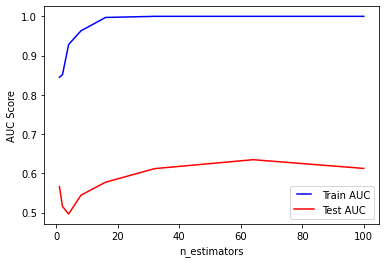

In [25]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]

train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('n_estimators')
plt.show()